In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
from scipy import stats
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV ,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Read Data

In [2]:
data = pd.read_csv(r'./data/Wage.csv')

In [3]:
data.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


# Data exploration

In [4]:
data.isnull().sum()

year          0
age           0
sex           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

data has no missing values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   sex         3000 non-null   object 
 3   maritl      3000 non-null   object 
 4   race        3000 non-null   object 
 5   education   3000 non-null   object 
 6   region      3000 non-null   object 
 7   jobclass    3000 non-null   object 
 8   health      3000 non-null   object 
 9   health_ins  3000 non-null   object 
 10  logwage     3000 non-null   float64
 11  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 281.4+ KB


In [6]:
data.duplicated().sum()

3

In [7]:
data = data.drop_duplicates()

In [8]:
data.duplicated().sum()

0

In [9]:
data.describe()

,year,age,logwage,wage
count,2997.000000,2997.000000,2997.000000,2997.000000
mean,2005.792125,42.412412,4.653377,111.626947
std,2.026155,11.546884,0.351380,41.626146
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.000000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


In [10]:
data.describe(exclude=[np.number])

,sex,maritl,race,education,region,jobclass,health,health_ins
count,2997,2997,2997,2997,2997,2997,2997,2997
unique,1,5,4,5,1,2,2,2
top,1. Male,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes
freq,2997,2071,2477,971,2997,1544,2139,2080


In [11]:
data.shape

(2997, 12)

In [12]:
data['maritl'].value_counts()

maritl
2. Married          2071
1. Never Married     648
4. Divorced          204
5. Separated          55
3. Widowed            19
Name: count, dtype: int64

In [13]:
data['race'].value_counts()

race
1. White    2477
2. Black     293
3. Asian     190
4. Other      37
Name: count, dtype: int64

In [14]:
data['education'].value_counts()

education
2. HS Grad            971
4. College Grad       685
3. Some College       650
5. Advanced Degree    423
1. < HS Grad          268
Name: count, dtype: int64

#  Feature engineering

## renaming columns

In [15]:
data.rename(columns = {'maritl':'marital_status','logwage':'log_wage','health_ins':'health_insurance'} ,inplace = True )

In [16]:
data.head()

,year,age,sex,marital_status,race,education,region,jobclass,health,health_insurance,log_wage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## Feature combination & edit

In [17]:
# education feature
data.education= data.education.replace(['1. < HS Grad','2. HS Grad'], 'school')
data.education= data.education.replace(['3. Some College','4. College Grad'], 'College')
data.education= data.education.replace(['5. Advanced Degree'], 'Advanced Degree')

In [18]:
# Martial status feature
data.marital_status= data.marital_status.replace(['2. Married'], 'Married')
data.marital_status= data.marital_status.replace(['1. Never Married'], 'single')
data.marital_status= data.marital_status.replace(['4. Divorced', '5. Separated','3. Widowed'], 'Other')

In [19]:
# race feature
data.race = data.race.replace(['1. White'],'White')
data.race = data.race.replace(['2. Black'],'Black')
data.race = data.race.replace(['3. Asian'],'Asian')
data.race = data.race.replace(['4. Other'],'Other')

In [20]:
# sex feature
data.sex = data.sex.replace(['1. Male'],'Male')

In [21]:
# region feature
data.region = data.region.replace(['2. Middle Atlantic'],'Middle Atlantic')

In [22]:
# jobclass feature
data.jobclass = data.jobclass.replace(['1. Industrial'],'Industrial')
data.jobclass = data.jobclass.replace(['2. Information'],'Information')

In [23]:
# health feature
data.health = data.health.replace(['1. <=Good'],'<=Good')
data.health = data.health.replace(['2. >=Very Good'],'>=Very Good')

In [24]:
# health_ins feature
data.health_insurance = data.health_insurance.replace(['1. Yes'],'Yes')
data.health_insurance = data.health_insurance.replace(['2. No'],'No')

In [25]:
# year feature
data.year = data.year.astype(str)

In [26]:
data.head()

,year,age,sex,marital_status,race,education,region,jobclass,health,health_insurance,log_wage,wage
0,2006,18,Male,single,White,school,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154
1,2004,24,Male,single,White,College,Middle Atlantic,Information,>=Very Good,No,4.255273,70.476020
2,2003,45,Male,Married,White,College,Middle Atlantic,Industrial,<=Good,Yes,4.875061,130.982177
3,2003,43,Male,Married,Asian,College,Middle Atlantic,Information,>=Very Good,Yes,5.041393,154.685293
4,2005,50,Male,Other,White,school,Middle Atlantic,Information,<=Good,Yes,4.318063,75.043154


# detecting outliers

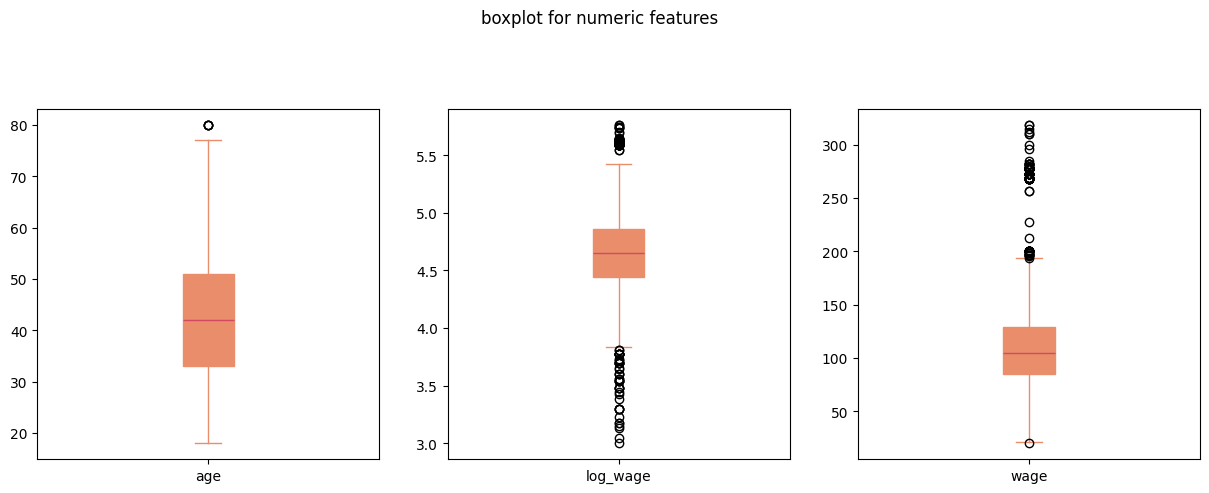

In [27]:
sns.set_palette("flare")
data.plot.box(subplots=True,layout=(2,3),figsize=(15,10),patch_artist=True,title='boxplot for numeric features')
plt.show()

we notice that log_wage is wage transformed form

# Triming outliers

## using IQR

In [28]:
data = data.sort_values(by=['wage'])
Q1 = data.wage.quantile(0.25)
Q3 = data.wage.quantile(0.75)
IQR= Q3-Q1
LC=Q1-(1.5*IQR)
UC=Q3+(1.5*IQR)
# outliers
data[(data.wage<LC) | (data.wage>UC)].shape

(109, 12)

In [29]:
data.drop(data[ (data.wage < LC) | (data.wage > UC) ].index , inplace=True)
data.shape

(2888, 12)

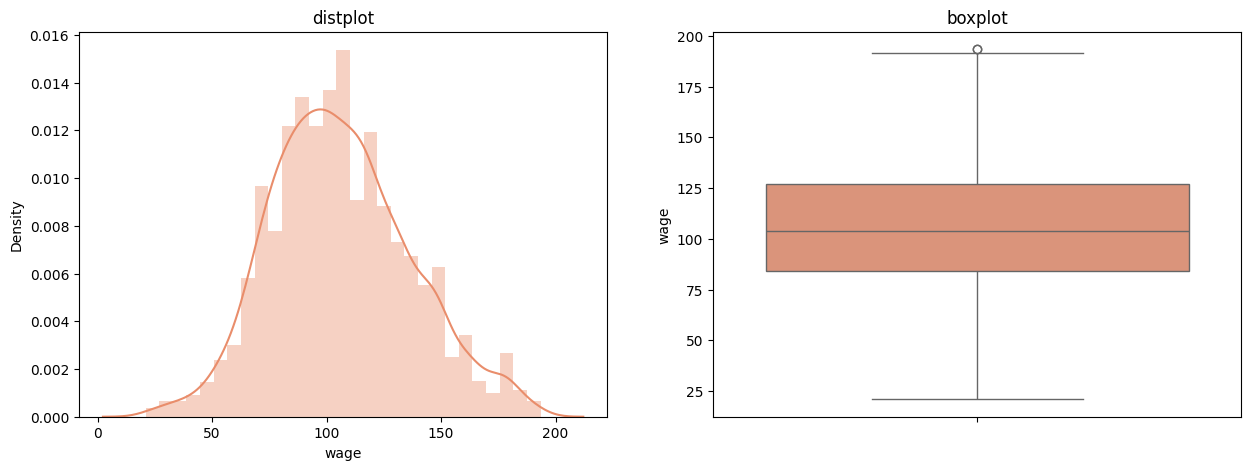

In [30]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

sns.distplot(data['wage'],ax=axes[0])
axes[0].set_title("distplot")

sns.boxplot(data['wage'],ax=axes[1])
axes[1].set_title("boxplot")

plt.show()

there exist two outliers after applying IQR method to remove outliers

In [31]:
print('first outlier : ',data.wage.max())
print('upper boundary : ',UC)

first outlier :  193.452606894109
upper boundary :  193.62530998308594


In [32]:
# Find outlier wage value
outlier = data['wage'].max()
# Drop rows containing outlier value
data = data.drop(data[data['wage'] == outlier].index)

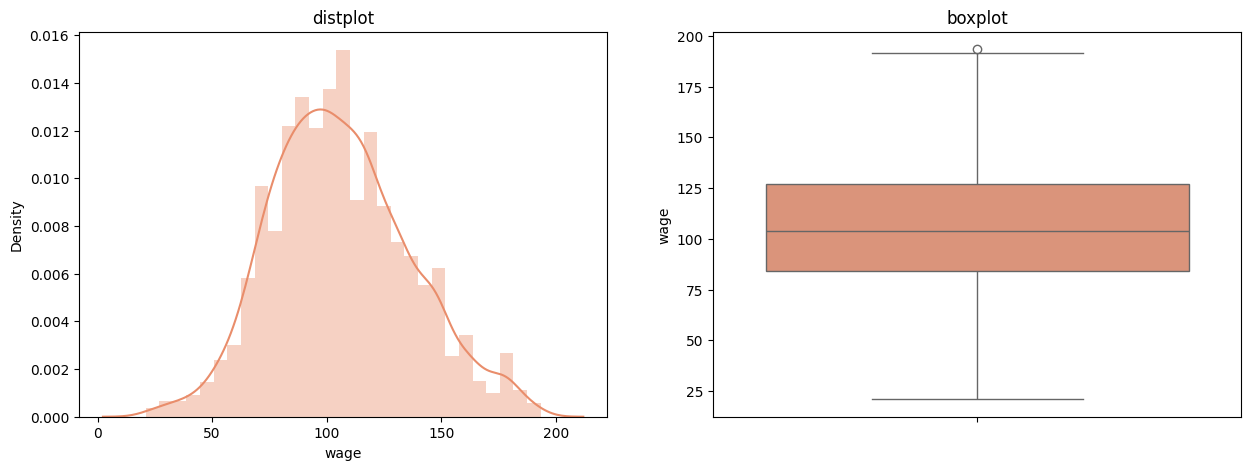

In [33]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

sns.distplot(data['wage'],ax=axes[0])
axes[0].set_title("distplot")

sns.boxplot(data['wage'],ax=axes[1])
axes[1].set_title("boxplot")

plt.show()

In [34]:
print('second outlier : ',data.wage.max())
print('upper boundary : ',UC)

second outlier :  193.411070530969
upper boundary :  193.62530998308594


In [35]:
# Find outlier wage value
outlier = data['wage'].max()
# Drop rows containing outlier value
data = data.drop(data[data['wage'] == outlier].index)

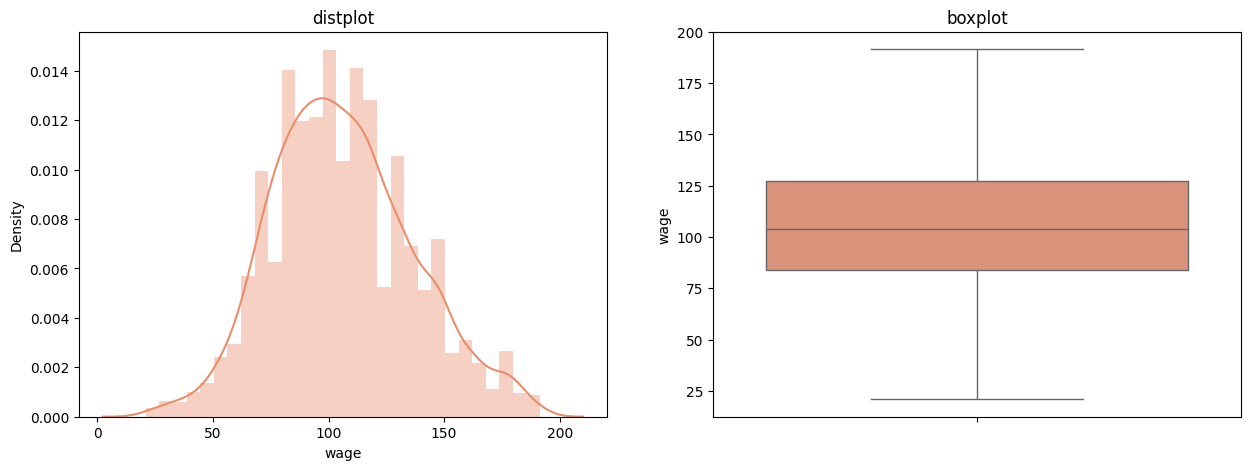

In [36]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

sns.distplot(data['wage'],ax=axes[0])
axes[0].set_title("distplot")

sns.boxplot(data['wage'],ax=axes[1])
axes[1].set_title("boxplot")

plt.show()

In [37]:
data.shape

(2886, 12)

# Data Transformation

In [38]:
# sqrt
data['sqrt_wage'] = np.sqrt(data['wage'])
# exponentioal 
data['exp_wage'] = np.exp(data['wage'])
# min max
data['minmax_wage']=((data.wage - data.wage.min())/(data.wage.max() - data.wage.min()))*(1-0) + 0
# zscore
data['zscore_wage'] = (data.wage - np.mean(data.wage)) / np.std(data.wage)

In [39]:
data.describe().round(2)

,age,log_wage,wage,sqrt_wage,exp_wage,minmax_wage,zscore_wage
count,2886.00,2886.00,2886.00,2886.00,2.886000e+03,2886.00,2886.00
mean,42.27,4.62,106.20,10.19,2.632868e+80,0.50,0.00
std,11.60,0.31,30.53,1.51,6.009053e+81,0.18,1.00
min,18.00,3.04,20.93,4.58,1.235051e+09,0.00,-2.79
25%,33.00,4.43,84.05,9.17,3.167347e+36,0.37,-0.73
50%,42.00,4.64,103.90,10.19,1.331281e+45,0.49,-0.08
75%,50.00,4.85,127.12,11.27,1.605706e+55,0.62,0.69
max,80.00,5.26,191.57,13.84,1.582682e+83,1.00,2.80


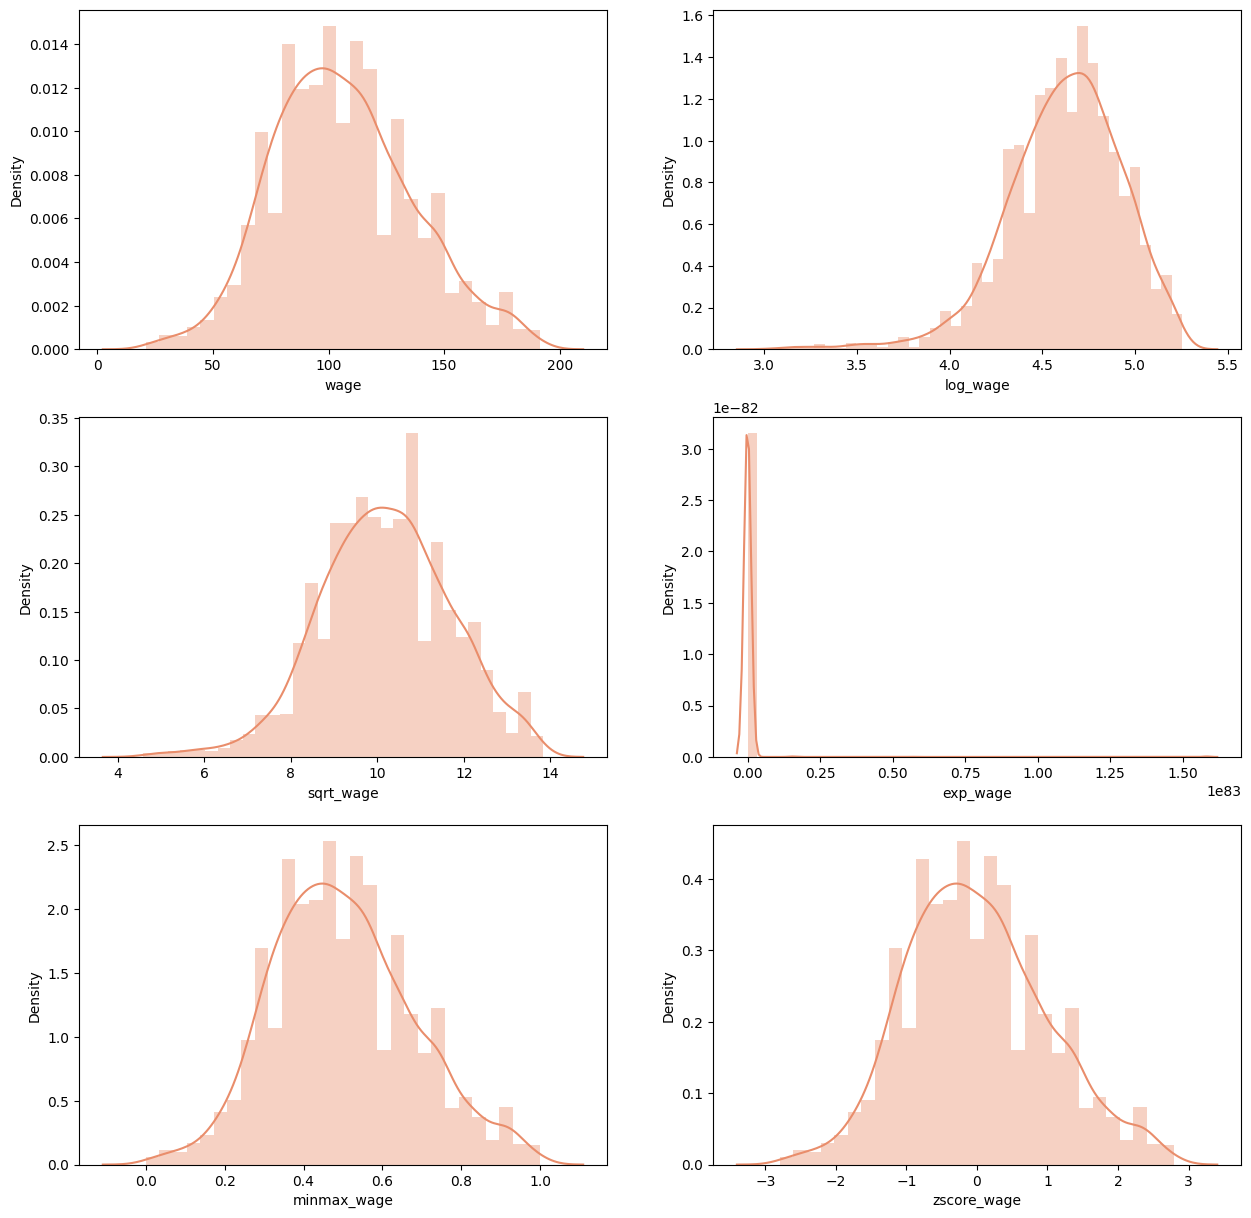

In [40]:
fig,axes = plt.subplots(3,2,figsize=(15,15))
sns.distplot(data.wage,ax=axes[0,0])
sns.distplot(data.log_wage,ax=axes[0,1])
sns.distplot(data.sqrt_wage,ax=axes[1,0])
sns.distplot(data.exp_wage,ax=axes[1,1])
sns.distplot(data.minmax_wage,ax=axes[2,0])
sns.distplot(data.zscore_wage,ax=axes[2,1])
plt.show()

In [41]:
print('wage skewness : ',data.wage.skew())
print('log wage skewness : ',data.log_wage.skew())
print('sqrt wage skewness : ',data.sqrt_wage.skew())
print('exp wage skewness : ',data.exp_wage.skew())
print('minmax wage skewness : ',data.minmax_wage.skew())
print('zscore wage skewness : ',data.zscore_wage.skew())

wage skewness :  0.2816999259669798
log wage skewness :  -0.7604450733604917
sqrt wage skewness :  -0.16733754058781564
exp wage skewness :  25.533635986997684
minmax wage skewness :  0.28169992596697974
zscore wage skewness :  0.2816999259669797


In [42]:
print('wage kurtosis : ',data.wage.kurt())
print('log wage kurtosis : ',data.log_wage.kurt())
print('sqrt wage kurtosis : ',data.sqrt_wage.kurt())
print('exp wage kurtosis : ',data.exp_wage.kurt())
print('minmax wage kurtosis : ',data.minmax_wage.kurt())
print('zscore wage kurtosis : ',data.zscore_wage.kurt())

wage kurtosis :  -0.12574873102897666
log wage kurtosis :  1.6034726562311907
sqrt wage kurtosis :  0.1498982142311709
exp wage kurtosis :  nan
minmax wage kurtosis :  -0.1257487310289771
zscore wage kurtosis :  -0.12574873102897666


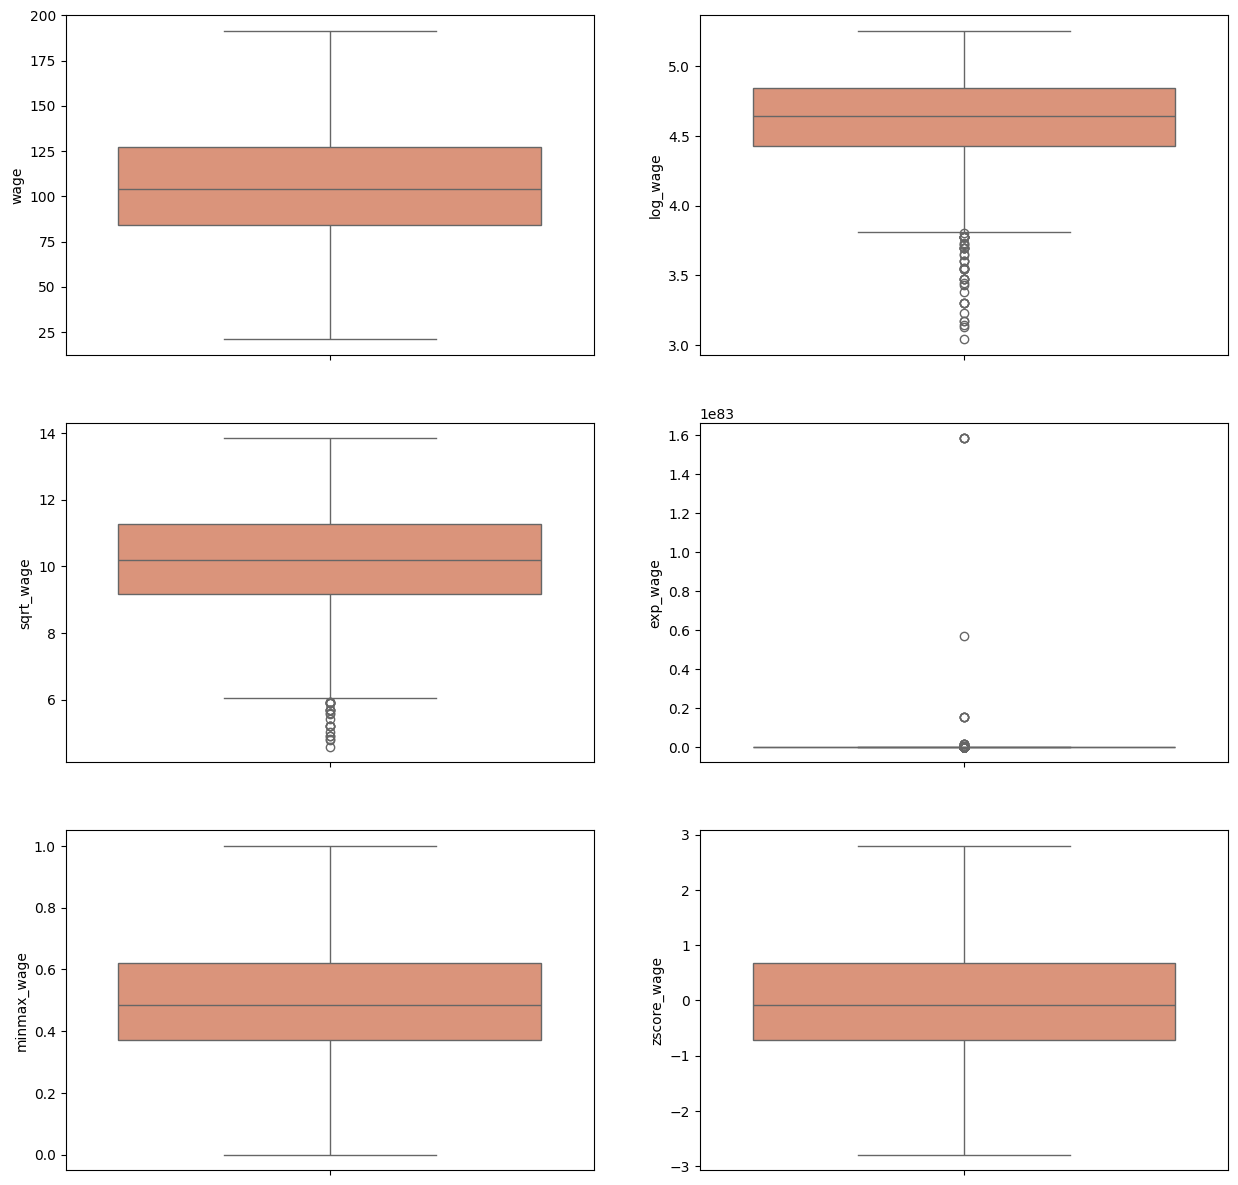

In [43]:
fig,axes = plt.subplots(3,2,figsize=(15,15))
sns.boxplot(data.wage,ax=axes[0,0])
sns.boxplot(data.log_wage,ax=axes[0,1])
sns.boxplot(data.sqrt_wage,ax=axes[1,0])
sns.boxplot(data.exp_wage,ax=axes[1,1])
sns.boxplot(data.minmax_wage,ax=axes[2,0])
sns.boxplot(data.zscore_wage,ax=axes[2,1])
plt.show()

# Q-Q plot

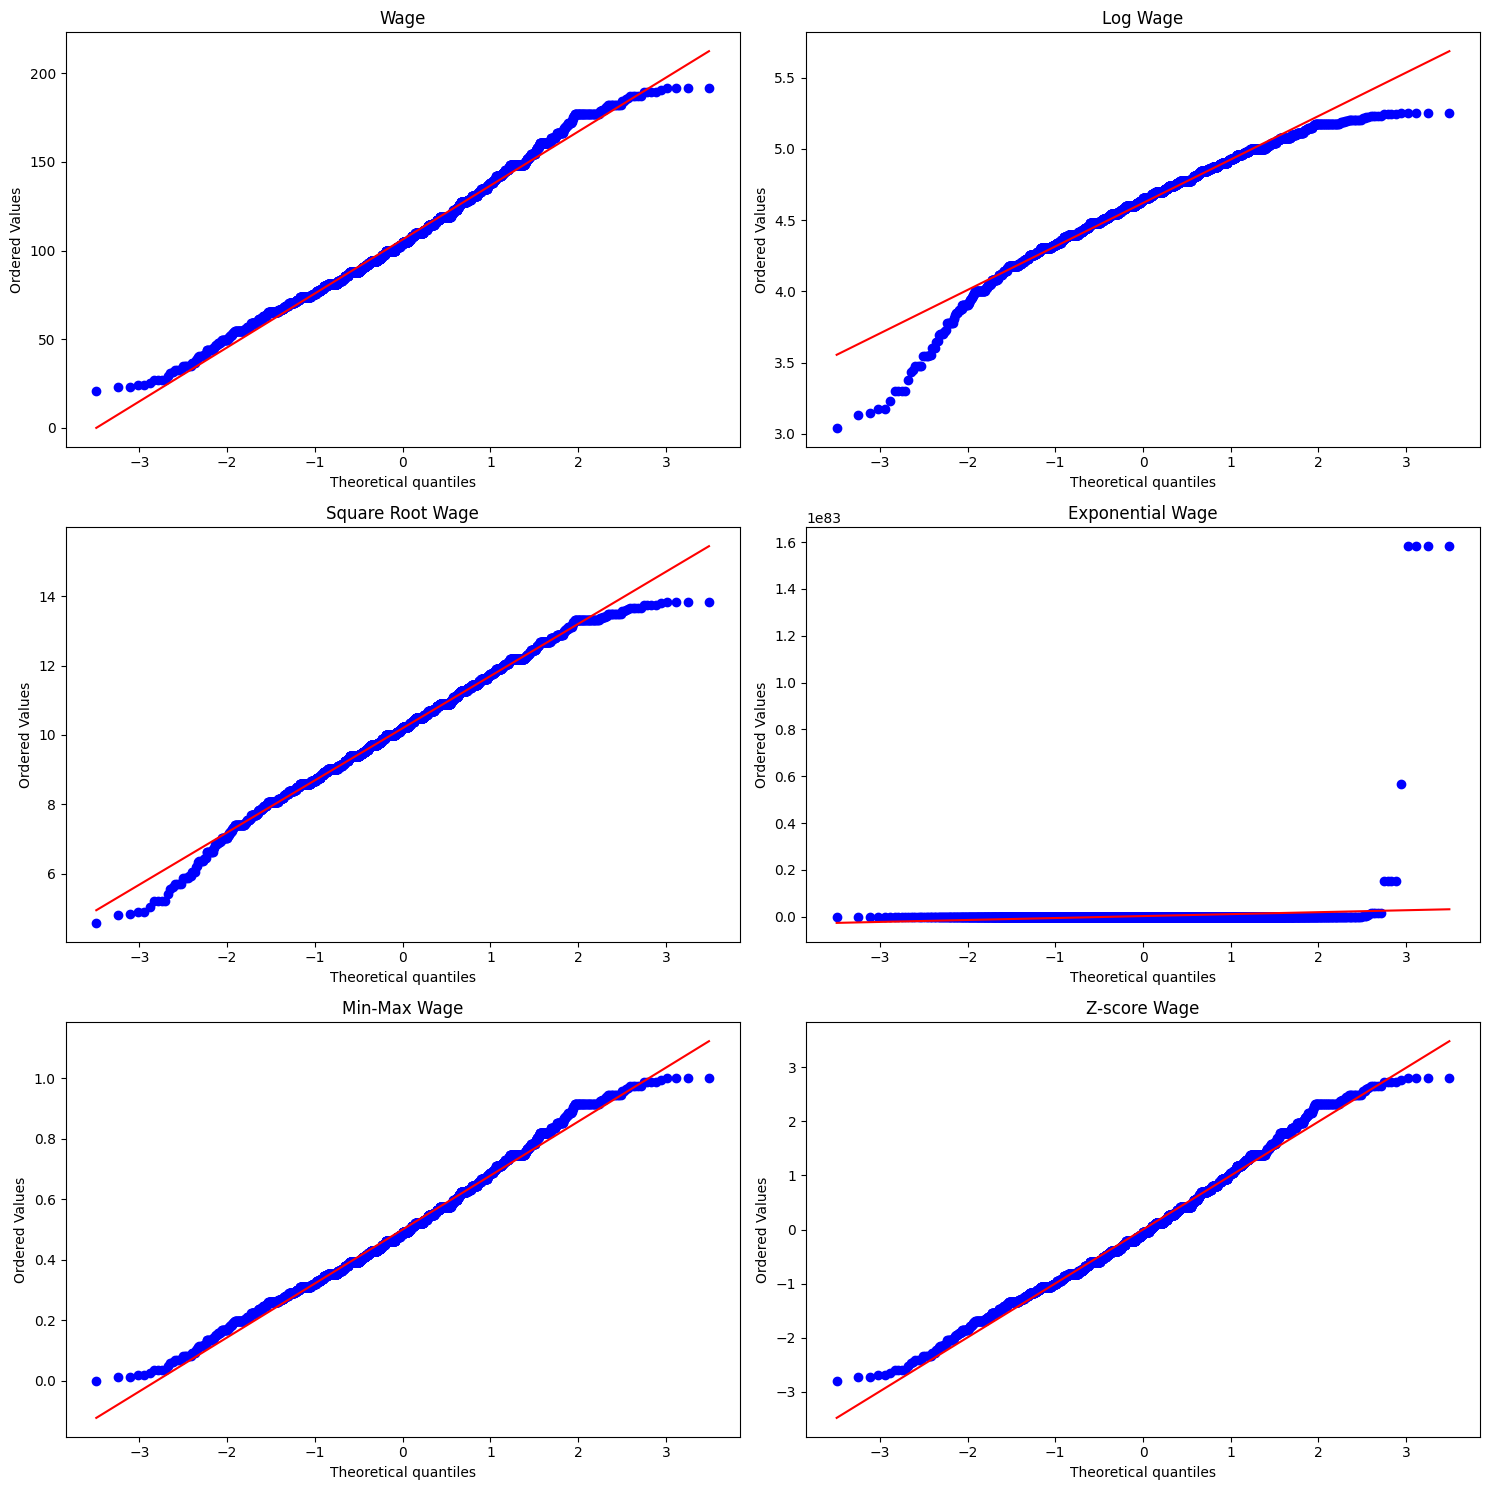

In [44]:
fig,axes = plt.subplots(3,2,figsize=(15,15))
stats.probplot(data.wage, dist="norm", plot=axes[0,0])
axes[0,0].set_title("Wage")

stats.probplot(data.log_wage,dist="norm",plot=axes[0,1])
axes[0,1].set_title("Log Wage")

stats.probplot(data.sqrt_wage,dist="norm",plot=axes[1,0])
axes[1,0].set_title("Square Root Wage")

stats.probplot(data.exp_wage,dist="norm",plot=axes[1,1])
axes[1,1].set_title("Exponential Wage")

stats.probplot(data.minmax_wage,dist="norm",plot=axes[2,0])
axes[2,0].set_title("Min-Max Wage")

stats.probplot(data.zscore_wage,dist="norm",plot=axes[2,1])
axes[2,1].set_title("Z-score Wage")

plt.tight_layout() 
plt.show()

### zcore/min-max transformation appears to be the most effective at making the wage data conform closer to a normal distribution

In [45]:
data.describe().round(2)

,age,log_wage,wage,sqrt_wage,exp_wage,minmax_wage,zscore_wage
count,2886.00,2886.00,2886.00,2886.00,2.886000e+03,2886.00,2886.00
mean,42.27,4.62,106.20,10.19,2.632868e+80,0.50,0.00
std,11.60,0.31,30.53,1.51,6.009053e+81,0.18,1.00
min,18.00,3.04,20.93,4.58,1.235051e+09,0.00,-2.79
25%,33.00,4.43,84.05,9.17,3.167347e+36,0.37,-0.73
50%,42.00,4.64,103.90,10.19,1.331281e+45,0.49,-0.08
75%,50.00,4.85,127.12,11.27,1.605706e+55,0.62,0.69
max,80.00,5.26,191.57,13.84,1.582682e+83,1.00,2.80


### we choose to apply min-max transformation

In [46]:
data = data.drop(['log_wage', 'wage','sqrt_wage','exp_wage','zscore_wage'], axis=1)

In [47]:
#  feature selection +ecode catetigoral features
data.describe()

,age,minmax_wage
count,2886.000000,2886.000000
mean,42.268538,0.499657
std,11.603724,0.178910
min,18.000000,0.000000
25%,33.000000,0.369854
50%,42.000000,0.486219
75%,50.000000,0.622256
max,80.000000,1.000000


In [48]:
data.describe(exclude=[np.number])

,year,sex,marital_status,race,education,region,jobclass,health,health_insurance
count,2886,2886,2886,2886,2886,2886,2886,2886,2886
unique,7,1,3,4,3,1,2,2,2
top,2003,Male,Married,White,College,Middle Atlantic,Industrial,>=Very Good,Yes
freq,496,2886,1973,2382,1295,2886,1522,2044,1986


# Age binning
 Binning can be a useful technique for reducing the impact of noise in data
 age need to be binned.

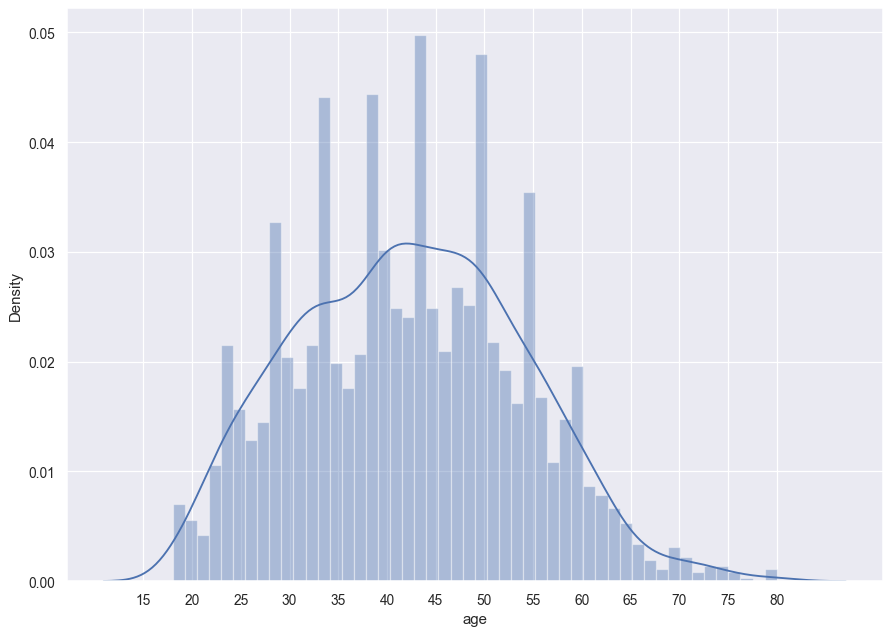

In [49]:
# Note that age is normal dist
sns.set(rc={'figure.figsize':(11.7,8.27),'figure.dpi':90})
sns.distplot(x=data["age"],kde=True,bins=50)
plt.xticks(np.arange(15,85,5))
plt.xlabel("age")
plt.show()

In [50]:
data['age_groups'] = pd.cut(data['age'],bins = [18, 25, 35, 50, 60, 80],
                         labels=['Young adult', 'Early thirties', 'Middle-aged', 'Late middle-aged', 'Senior'])

In [51]:
data.head()

,year,age,sex,marital_status,race,education,region,jobclass,health,health_insurance,minmax_wage,age_groups
388,2004,33,Male,Married,White,school,Middle Atlantic,Information,>=Very Good,No,0.000000,Early thirties
499,2003,52,Male,Other,White,College,Middle Atlantic,Industrial,<=Good,No,0.011885,Late middle-aged
2670,2003,27,Male,single,Black,school,Middle Atlantic,Information,>=Very Good,No,0.013715,Early thirties
2664,2003,48,Male,Other,White,school,Middle Atlantic,Industrial,<=Good,No,0.017690,Middle-aged
1829,2003,38,Male,Married,White,College,Middle Atlantic,Information,<=Good,No,0.017690,Middle-aged


In [52]:
data['age_groups'].value_counts()

age_groups
Middle-aged         1279
Early thirties       657
Late middle-aged     554
Young adult          220
Senior               165
Name: count, dtype: int64

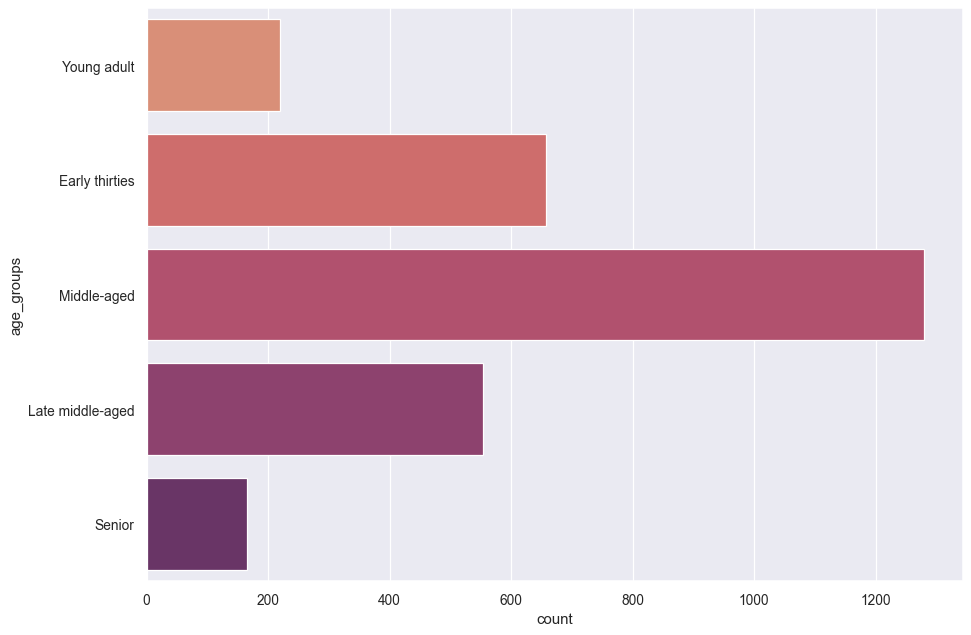

In [53]:
sns.countplot(data['age_groups'], palette='flare')
plt.show()

In [54]:
data = data.drop(['age'], axis=1)

# Encoding
Encoding is a method from the sklearn library, It is used to transform categorical or optimal data to numerical data based on which method will be chosen.
LabelEncoder( ) is better with optimal data or categorical with less number of labels in one feature.

In the One-Hot encoder, each category is represented by a binary vector with a length equal to the number of categories present in the data. We replace the similar labels in Education feature with the same, decreasing the number that will not affect the accuracy.

In [55]:
tr = preprocessing.LabelEncoder()
data['sex'] = tr.fit_transform(data['sex'])
data['region'] = tr.fit_transform(data['region'])
data['jobclass'] = tr.fit_transform(data['jobclass'])
data['health'] = tr.fit_transform(data['health'])
data['health_insurance'] = tr.fit_transform(data['health_insurance'])

In [56]:
data.head()

,year,sex,marital_status,race,education,region,jobclass,health,health_insurance,minmax_wage,age_groups
388,2004,0,Married,White,school,0,1,1,0,0.000000,Early thirties
499,2003,0,Other,White,College,0,0,0,0,0.011885,Late middle-aged
2670,2003,0,single,Black,school,0,1,1,0,0.013715,Early thirties
2664,2003,0,Other,White,school,0,0,0,0,0.017690,Middle-aged
1829,2003,0,Married,White,College,0,1,0,0,0.017690,Middle-aged


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2886 entries, 388 to 1026
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   year              2886 non-null   object  
 1   sex               2886 non-null   int32   
 2   marital_status    2886 non-null   object  
 3   race              2886 non-null   object  
 4   education         2886 non-null   object  
 5   region            2886 non-null   int32   
 6   jobclass          2886 non-null   int32   
 7   health            2886 non-null   int32   
 8   health_insurance  2886 non-null   int32   
 9   minmax_wage       2886 non-null   float64 
 10  age_groups        2875 non-null   category
dtypes: category(1), float64(1), int32(5), object(4)
memory usage: 194.7+ KB


In [58]:
data.describe(exclude=[np.number])

,year,marital_status,race,education,age_groups
count,2886,2886,2886,2886,2875
unique,7,3,4,3,5
top,2003,Married,White,College,Middle-aged
freq,496,1973,2382,1295,1279


In [59]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns
# Perform one-hot encoding on the categorical columns
data = pd.get_dummies(data, columns=cat_cols)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2886 entries, 388 to 1026
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sex                          2886 non-null   int32  
 1   region                       2886 non-null   int32  
 2   jobclass                     2886 non-null   int32  
 3   health                       2886 non-null   int32  
 4   health_insurance             2886 non-null   int32  
 5   minmax_wage                  2886 non-null   float64
 6   year_2003                    2886 non-null   bool   
 7   year_2004                    2886 non-null   bool   
 8   year_2005                    2886 non-null   bool   
 9   year_2006                    2886 non-null   bool   
 10  year_2007                    2886 non-null   bool   
 11  year_2008                    2886 non-null   bool   
 12  year_2009                    2886 non-null   bool   
 13  marital_status_Marrie

In [61]:
data.shape

(2886, 28)

# Feature Selection and Dimensionality Reduction

### Select KBest Method

In [62]:
# Split the data into X and y
X = data.drop('health', axis=1)
y = data['health']

# Define the parameter grid for SelectKBest
param_grid = {
    'k': [10, 15, 20, 25, 27]
}

# Create a SelectKBest object
select = SelectKBest(score_func=f_regression)

# Create a GridSearchCV object
grid_search = GridSearchCV(select, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best value of k
best_k = grid_search.best_params_['k']

# Fit SelectKBest to the data with the best value of k
select = SelectKBest(score_func=f_regression, k=best_k)
select.fit(X, y)

# Get the selected features
selected_feature = X.columns[select.get_support()]

# Print the selected features and best value of k
print("Selected features:", selected_feature)
print("Best value of k:", best_k)

Selected features: Index(['jobclass', 'health_insurance', 'minmax_wage', 'marital_status_Other',
       'education_Advanced Degree', 'education_College', 'education_school',
       'age_groups_Early thirties', 'age_groups_Late middle-aged',
       'age_groups_Senior'],
      dtype='object')
Best value of k: 10


In [63]:
correl = data[selected_feature].corrwith(data["health"]).to_frame()
correl

,0
jobclass,0.060998
health_insurance,0.069804
minmax_wage,0.150338
marital_status_Other,-0.059109
education_Advanced Degree,0.099915
education_College,0.079420
education_school,-0.146337
age_groups_Early thirties,0.084862
age_groups_Late middle-aged,-0.091679
age_groups_Senior,-0.104604


In [64]:
correl = correl.rename(columns={0: "health"})
correl

,health
jobclass,0.060998
health_insurance,0.069804
minmax_wage,0.150338
marital_status_Other,-0.059109
education_Advanced Degree,0.099915
education_College,0.079420
education_school,-0.146337
age_groups_Early thirties,0.084862
age_groups_Late middle-aged,-0.091679
age_groups_Senior,-0.104604


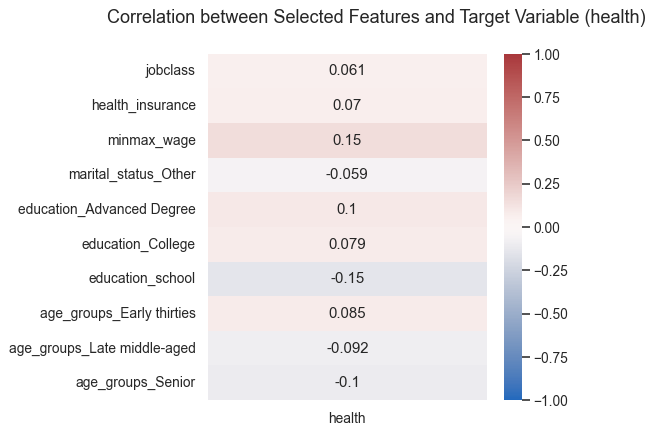

In [65]:
fig=plt.figure(figsize=(5,5))
fig.suptitle('Correlation between Selected Features and Target Variable (health)')
sns.heatmap(correl, annot=True, cmap='vlag',vmin=-1, vmax=1)
plt.show()

# Logistic regression (classification)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
print("Acc on training data: {:,.3f}".format(lr.score(X_train, y_train)))
prediction = model.predict(X_test)
print("Acc on test data: {:,.3f}".format(lr.score(X_test, y_test)))

Acc on training data: 0.720
Acc on test data: 0.713


# Model evaluation & confusion matrix

In [67]:
accuracy_score(prediction, y_test.values)

0.7132963988919667

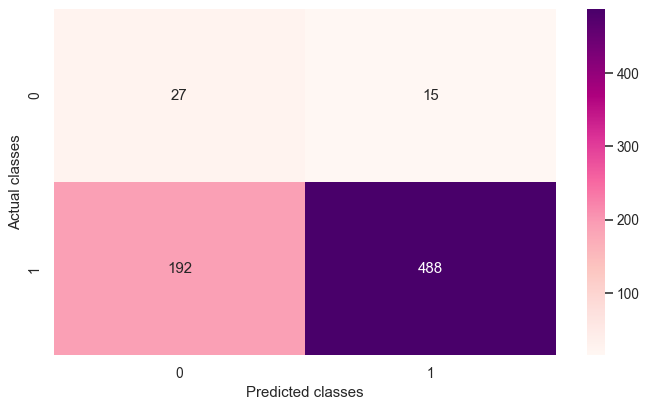

In [68]:
sns.set(rc={'figure.figsize':(9,5)})
cfm = confusion_matrix(prediction, y_test.values)
sns.heatmap(cfm, annot=True, fmt="d",cmap="RdPu")
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.show()

In [69]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.64      0.12      0.21       219
           1       0.72      0.97      0.83       503

    accuracy                           0.71       722
   macro avg       0.68      0.55      0.52       722
weighted avg       0.69      0.71      0.64       722

